In [4]:
import math
import numpy as np
from scipy import signal
from PIL import Image, ImageDraw
from scipy.ndimage import gaussian_filter
import os

### Part 1

Question 1-2

In [5]:
import ncc

In [50]:

def MakeGaussianPyramind(image, scale, minsize):
    '''
    purpose: creates a pyramid for an image
    inputs: image - jpg, scale - factor by which to reduce image size, minsize - min dimension of reduced image
    outputs: list of [original_image, PIL images of reduced size]
    '''
    # generate appropriate sigma
    sigma=1/(2*scale)
    # open image
    im = Image.open(image)
    pyr = []
    pyr.append(np.float32(im))
    # set while loop with min dim as stop condition
    x, y = im.height, im.width
    min_dim = np.max([x, y])
    while int(min_dim*0.75) > minsize: # check condition
        if len(im.size) < 3: # if grayscale, do not split channels for separate filtering
            im2 = Image.fromarray(gaussian_filter(im, sigma))
            # resize image
            imnew = im2.resize((int(x*scale), int(y*scale)), Image.BICUBIC)
            # convert back to np array
            resized = np.float32(imnew)
        else:
            r, g, b = im.split() # if multi-channel, split channels and filter before reassmbeling
            r, g, b = Image.fromarray(gaussian_filter(r, sigma)), Image.fromarray(gaussian_filter(g, sigma)), Image.fromarray(gaussian_filter(b, sigma))
            im2 = Image.merge(r,g,b)
            # resize image
            imnew = im2.resize((int(x*scale), int(y*scale)), Image.BICUBIC)
            # convert back to numpy arrays 
            r, b, g = imnew.split()
            resized = np.array([np.float32(r), np.float32(b), np.float32(g)])
        pyr.append(resized)
        # update min_dim
        x, y = imnew.height, imnew.width
        min_dim = np.max([x, y])
    return pyr
        

In [57]:
print(os.getcwd())
filepath=r"hw2part2\faces\judybats.jpg"
pyr = MakeGaussianPyramind(image=filepath, scale=0.75, minsize=50)
print('done')

c:\Users\Sadie\Documents\GitHub\CPSC_425\A2
done


Question 3

In [58]:
def ShowGaussianPyramid(pyr):
    '''
    purpose: display Gaussian pyramid
    inputs: list of np arrays
    outputs: None (display all images in pyramid side by side)
    '''
    heights = list(map(lambda x: x.shape[0], pyr)) # get dims of all imgs in list to know dims needed for template image
    widths = list(map(lambda x: x.shape[1], pyr))
    w_tot, h_tot = np.sum(widths), np.max(heights)
    image = Image.new(mode="L", size=(w_tot, h_tot), color="#ffff")
    offset_x, offset_y = 0, 0
    for im in pyr:
        im_pil = Image.fromarray(im)
        image.paste(im_pil,(offset_x, offset_y))
        offset_x += im_pil.width
        #offset_y = im_pil.height
    print(image.size)
    display(image)

(1215, 342)


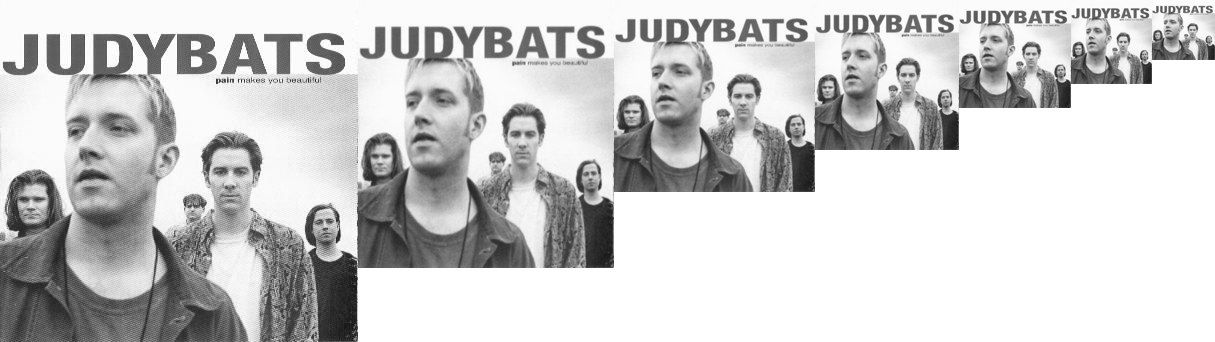

In [59]:
ShowGaussianPyramid(pyr)

Question 4

In [ ]:
def FindTemplate(pyramid, template, threshold):
    '''
    purpose: find and mark regions in set of images where template matches above a certain threshold
    inputs: list of images (pyramid), template, threshold for matching
    outputs: annotated image
    '''
    # reduce template size
    temp_w = 15
    ar = template.height / template.width # keep same aspect ratio
    template = template.resize((temp_w,int(temp_w*ar)), Image.BICUBIC)
    # loop through images
    first_im = Image.fromarray(pyramid[0])
    for i, im in enumerate(pyramid):
        res = ncc.normxcorr2D(im, template)
        Image.fromarray(res).save(f"corr_{i}.tif")
        x, y = np.where(res > threshold)
        for j in range(len(x)):
            def rescale_x(x):
                ''' 
                purpose: rescale a x coordinate from a smaller image to correspond to the same location in a larger image
                input: x, the coordinate
                '''
                return (x/Image.fromarray(im).width)*first_im.width
            
            def rescale_y(y):
                ''' 
                purpose: rescale a y coordinate from a smaller image to correspond to the same location in a larger image
                input: y, the coordinate
                '''
                return (y/Image.fromarray(im).height)*first_im.height
            # create corners of box to be drawn
            x1,y1 = rescale_x(x[j]),rescale_y(y[j]) #,rescale_x(x2),rescale_y(y2)
            x1, x2 = x1 - template.width, x1 + template.width
            y1, y2 = y1 - template.height, y1 + template.height
            # rescale coordinates of high correlation for plotting on original image
            
            draw = ImageDraw.Draw(first_im)
            draw.line((x1,y1,x2,y2),fill="red",width=3)
            del draw
        #if len(x) > temp_w:
        #    # find coords of max size box for plotting
        #    x1,y1,x2,y2 = np.min(x), np.min(y), np.max(x), np.max(y)
        #    
        #    def rescale_x(x):
        #        ''' 
        #        purpose: rescale a x coordinate from a smaller image to correspond to the same location in a larger image
        #        input: x, the coordinate
        #        '''
        #        return (x*Image.fromarray(im).width)/first_im.width
        #    
        #    def rescale_y(y):
        #        ''' 
        #        purpose: rescale a y coordinate from a smaller image to correspond to the same location in a larger image
        #        input: y, the coordinate
        #        '''
        #        return (y*Image.fromarray(im).height)/first_im.height
        #    # rescale for plotting on original image
        #    x1,y1,x2,y2 = rescale_x(x1),rescale_y(y1),rescale_x(x2),rescale_y(y2)
        #    # draw lines for detections
        #    draw = ImageDraw.Draw(first_im)
        #    draw.line((x1,y1,x2,y2),fill="red",width=2)
            # del draw
    # show result
    display(first_im)
    first_im.save("template_match.tif")
            

In [100]:
temp = Image.open(r"hw2part2\faces\template.jpg")
FindTemplate(pyr, temp, 0.8)

c:\Users\Sadie\Documents\GitHub\CPSC_425\A2\ncc.py:59: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


<PIL.Image.Image image mode=F size=358x342>

Question 5